# Problem \# 2: Generative Models

#### Author: Fan Lu
#### Date: 04/25/2023

In [1]:
# All the necessary Python modules are imported here.
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras import layers

# Used to visualize the two NNs
import pydot
from tensorflow.keras.utils import plot_model
import keras
keras.utils.vis_utils.pydot = pydot

# Used to import images and display them
from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt

# renders the figure in a notebook and stored in the notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [25, 5]

# Get Library Versions
print('\n'.join(f'{m.__name__}=={m.__version__}' 
                for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.23.5
tensorflow==2.10.1
pydot==1.4.2
keras==2.10.0
matplotlib==3.5.2


In [2]:
# Use GPU for Training?
def useGPU(GPU):
    if tf.config.list_physical_devices('GPU') is not None and GPU:
        tf.debugging.set_log_device_placement(True)
        print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    # Trun off all GPUs
    else:
        try:
            # Disable all GPUS
            tf.config.set_visible_devices([], 'GPU')
            visible_devices = tf.config.get_visible_devices()
            for device in visible_devices:
                assert device.device_type != 'GPU'
        except:
            # Invalid device or cannot modify virtual devices once initialized.
            pass

In [3]:
# Def Generator NN
def get_generator(noise_dim, minVal, maxVal):
    # MLP
    inputs = layers.Input(shape = (noise_dim,))
    out = layers.Dense(128, activation = "leaky_relu")(inputs)
    out = layers.Dense(128, activation = "leaky_relu")(out)
    outputs = layers.Dense(1, activation = "sigmoid")(out)
    
    # constraint the output to the age range in training [minVal, maxVal]
    scale = maxVal - minVal
    outputs = outputs * scale + minVal
    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    return model

# Def Discriminator NN
def get_discriminator():
    # MLP
    inputs = layers.Input(shape = (1,))
    out = layers.Dense(128, activation = "leaky_relu")(inputs)
    out = layers.Dense(128, activation = "leaky_relu")(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    return model

## Loss Functions
### Objective:
$$\min_{G} \max_{D} V(D, G) $$
$$ V(D, G) = \mathbb{E}_{x\sim P_{\text{data}}} [\log D(x)] + \mathbb{E}_{z\sim P_{\text{noise}}} [1 - \log D(G(z))]$$

### Binary Cross Entropy Loss
$$ \text{Cost}(Y, Z) = \frac{1}{M}\sum \max(Z, 0) - ZY + \log(1 + e^{-|Z|}) $$

In [4]:
# Loss of discriminator

# This method returns a helper function to compute cross entropy loss
# making from_logits true allows second par to be within [-inf, inf]
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
def discriminator_loss(real_output, fake_output):
    # We want 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Loss of Generators
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [5]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(ages, BATCH_SIZE, noise_dim):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_ages = generator(noise, training=True)
        real_output = discriminator(ages, training=True)
        fake_output = discriminator(generated_ages, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training
def train(dataset, epochs, BATCH_SIZE, noise_dim):
    genLoss, discLoss = [], []
    for epoch in range(epochs):
        gen_loss_Sum, discLoss_Sum = 0, 0
        cnt = 0
        for age_batch in dataset:
            gen_loss, disc_loss = train_step(age_batch, BATCH_SIZE, noise_dim)
            gen_loss_Sum += gen_loss.numpy()
            discLoss_Sum += disc_loss.numpy()
            cnt += 1
        genLoss.append(gen_loss / cnt)
        discLoss.append(disc_loss / cnt)
        print('\r Epoch: {}/{} GenLoss: {:.4f} DiscLoss: {:.4f}'.format(
                epoch + 1, epochs, gen_loss / cnt, disc_loss / cnt), end = " ")
    return genLoss, discLoss

## Coordination of Generator Model and Discriminator Model
GANs consist of two main parts, the generator and the discriminator, which are both neural networks. The generator generates new data instances while the discriminator evaluates them and tries to distinguish them from real data instances. The two networks are trained together in an adversarial process, where the generator tries to produce more convincing data instances to fool the discriminator, while the discriminator tries to become better at distinguishing between the real and fake data instances.

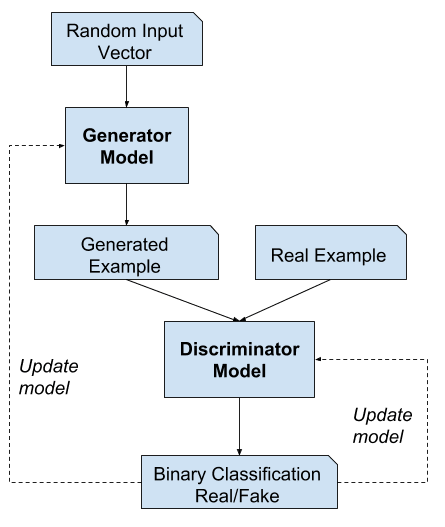

In [12]:
Image("data/GANArch.png")

## Data Processing and Training

In [7]:
# Fix random seed for consistency accross runs
tf.random.set_seed(0)
# Number of epochs for training
EPOCHS = 200
# dimension of noise (the input of NNs)
noise_dim = 300
# batch size
BATCH_SIZE = 128
# Buffer size for shuffling
SHUFFLE_BUFFER_SIZE = 100

# useGPU(True)
# Data Preprocessing
dt = np.load('data/eICU_age.npy')
dt_org = np.array([d[0] for d in dt], dtype=np.float32).reshape(-1, 1)
# Calculate the min and max values in the dataset
minVal, maxVal = min(dt_org), max(dt_org)

# turn numpy array to tensors
train_dataset = tf.data.Dataset.from_tensor_slices((dt_org))
# Randomly shuffles the elements of this dataset with buffer_size elements
# with batch size = BATCH_SIZE
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# Use Adam as the optimizer of the two models
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Construct generator and discriminator NNs
generator = get_generator(noise_dim, minVal, maxVal)
discriminator = get_discriminator()

# Start training
t1 = time.time()
genLoss, discLoss = train(train_dataset, EPOCHS, BATCH_SIZE, noise_dim)
t2 = time.time()
print('\n Time Spent: {:.4f} sec'.format(t2 - t1))

 Epoch: 200/200 GenLoss: 0.0335 DiscLoss: 0.0694 
 Time Spent: 210.6544 sec


## Visualization

In [8]:
# Visulize the two models
plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True)
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


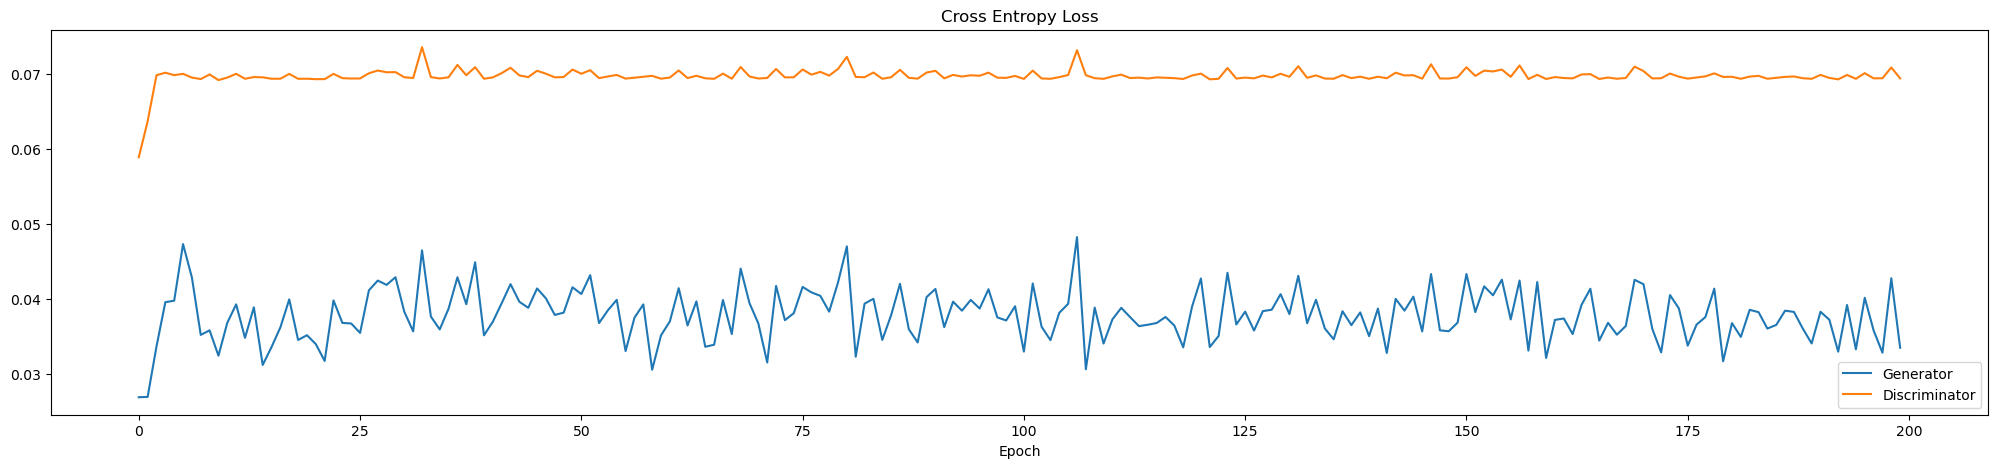

In [9]:
# Plot averaged cross entroy loss of each model during training
plt.plot(genLoss, label = 'Generator')
plt.plot(discLoss, label = 'Discriminator')
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.legend()

In [10]:
# Generate ages
# noise used to testing generator for generating testing samples
# number of samples to generate can be len(dt_org), but the more we generate, 
# the closer the generated distribution to the real one.
tf.random.set_seed(0)
num_examples_to_generate = 50000
test_dt = tf.random.normal([num_examples_to_generate, noise_dim])
# Generate ages using trained generator.
genAges = generator(test_dt, training = False)

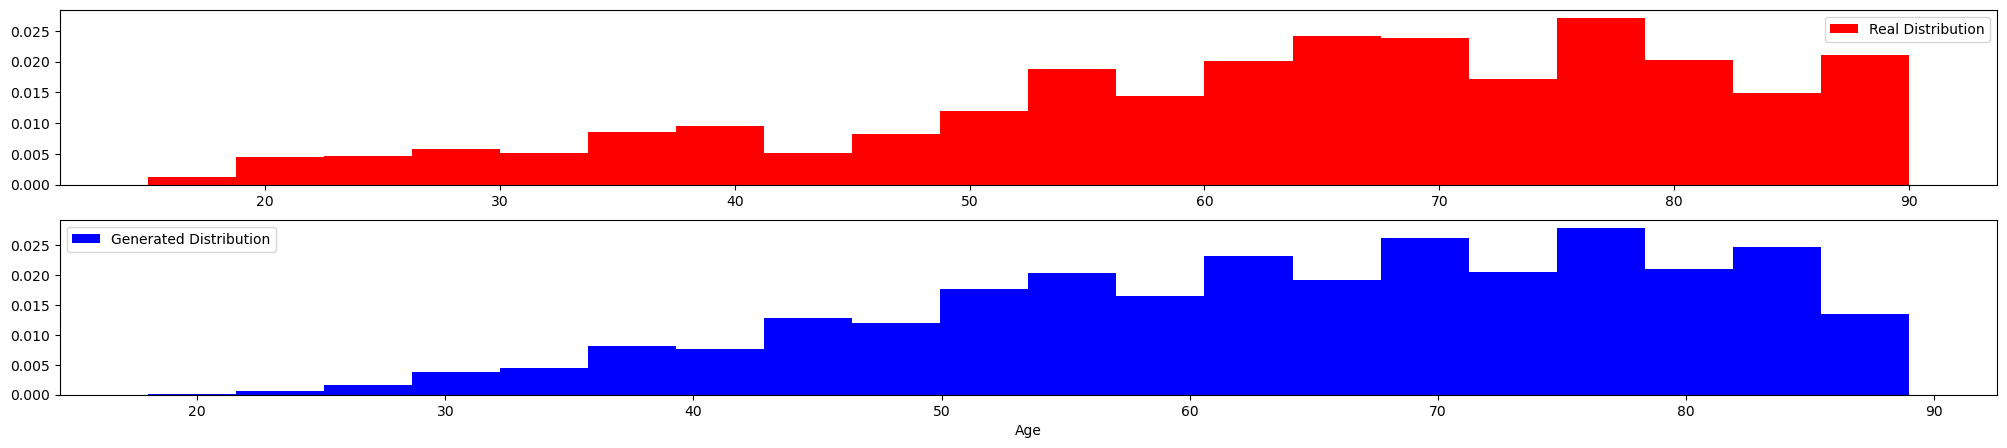

In [11]:
# Plot age distributions
plt.figure(num = 2)
plt.subplot(2,1,1)
plt.hist(dt_org, bins=20, color = 'red', label = 'Real Distribution', density=True)
plt.legend()
plt.subplot(2,1,2)
plt.hist(genAges.numpy().astype(int) , color = 'blue', bins=20, label = 'Generated Distribution', density=True)
plt.xlabel('Age')
plt.legend()